In [1]:
import argparse
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.optim import Adam
from simulators import *
from matrix_utils import *
from QCNN import *

In [2]:
def get_random_computational_ids(n_qubits, n_states=32):
    return np.random.randint(2 ** n_qubits, size=(n_states))


def convert_id_to_dm(ids, n_qubits):
    N = len(ids)
    dim = 2 ** n_qubits
    out = np.zeros((N, dim, dim), dtype=np.complex64)
    for i, id_i in enumerate(ids):
        out[i, id_i, id_i] = 1.
    out_tensor = torch.tensor(out, dtype=torch.complex64)
    out_tensor = out_tensor.reshape([N] + [2] * (2 * n_qubits))
    return out_tensor


def convert_id_to_state(ids, n_qubits):
    out = np.zeros((len(ids), 1, 2**n_qubits))
    for i, id_i in enumerate(ids):
        out[i,0,id_i] = 1.
    return torch.tensor(out.reshape([len(ids),1] + [2]*(n_qubits))).type(torch.complex64)


def accuracy(x, y):
    return torch.mean((torch.sgn(x-0.5)==torch.sgn(y-0.5)).type(torch.float32))

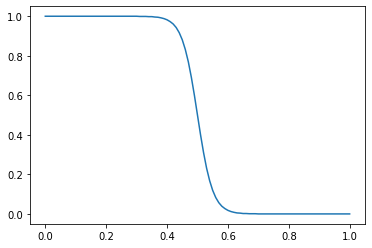

In [3]:
import matplotlib.pyplot as plt
def power_schedule(n, max_mu=0.35, t_stop = 0.75):
    def f(t):
        return max(max_mu * (1 - (t / t_stop) ** n), 0)
    return f

def tanh_schedule():
    return lambda t: round((1-np.tanh(20*(t-0.5))) / 2, 3)

# s = power_schedule(n=1, max_mu=0.8, t_stop=1.2)
s = tanh_schedule()
t = np.arange(0, 1+0.01, 0.01)
y = [s(x) for x in t]
plt.plot(t, y)

In [5]:
n = 4
train_size = 400
batch_size = 200
epochs = 1000
print_every = 1001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.005
device

device(type='cuda')

In [7]:
from tqdm import tqdm
import time
np.random.seed(1)
torch.manual_seed(1)

s = power_schedule(n=1, max_mu=0.8, t_stop=0.5)
target_QCNN = QCNN(n).to(device)
n_batches = train_size // batch_size

data_ids = get_random_computational_ids(n, train_size)
y = torch.zeros(len(data_ids)).to(device)
for batch_i in range(n_batches):
    data = convert_id_to_state(data_ids[batch_i*batch_size:(batch_i+1)*batch_size], n).to(device)
    with torch.no_grad():
        state = state_mixture_simulator(n, state_init = data, device = device)
        y[batch_i * batch_size:(batch_i + 1) * batch_size] = target_QCNN(state, mu=0.)

student_QCNN = QCNN(n).to(device)
init_nn_state = student_QCNN.state_dict().copy()

criterion = nn.MSELoss()
optim = Adam(student_QCNN.parameters(), lr=lr)

start = time.time()
for i in tqdm(range(1, epochs + 1)):
    epoch_loss = 0.
    epoch_acc = 0.
    for batch_i in range(n_batches):
        optim.zero_grad()
        data = convert_id_to_state(data_ids[batch_i * batch_size:(batch_i + 1) * batch_size], n).to(device)
        state = state_mixture_simulator(n, state_init=data, device=device)
        out = student_QCNN(state, mu=0.)
        loss = criterion(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
        loss.backward()
        optim.step()

        acc = accuracy(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
        epoch_loss += loss
        epoch_acc += acc

    epoch_loss = epoch_loss / n_batches
    epoch_acc = epoch_acc / n_batches
    if i % print_every == 0:
        print(epoch_loss.item(), epoch_acc.item())
end = time.time()
print(f'Classic opt: loss is {epoch_loss.item()}, accuracy is {epoch_acc.item()}')
print(f'Time took for training classical model: {end - start}')

student_QCNN = QCNN(n).to(device)
# Инициализируем те же самые параметры начальные
student_QCNN.load_state_dict(init_nn_state)
student_QCNN.noise_on = True


criterion = nn.MSELoss()
optim = Adam(student_QCNN.parameters(), lr=lr)

start = time.time()
for i in tqdm(range(1, epochs + 1)):
    epoch_loss = 0.
    epoch_acc = 0.
    mu = s(i / epochs)
    for batch_i in range(n_batches):
        optim.zero_grad()
        data = convert_id_to_state(data_ids[batch_i * batch_size:(batch_i + 1) * batch_size], n).to(device)
        state = state_mixture_simulator(n, state_init=data, device=device)
        out = student_QCNN(state, mu=mu)
        loss = criterion(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
        loss.backward()
        optim.step()

        acc = accuracy(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
        epoch_loss += loss
        epoch_acc += acc

    epoch_loss = epoch_loss / n_batches
    epoch_acc = epoch_acc / n_batches
    if i % print_every == 0:
        print(epoch_loss.item(), epoch_acc.item())
end = time.time()
print(f'Noisy opt: loss is {epoch_loss.item()}, accuracy is {epoch_acc.item()}')
print(f'Time took for training noise-induced model: {end - start}')

100%|██████████| 1000/1000 [00:15<00:00, 63.08it/s]


Classic opt: loss is 0.0059602633118629456, accuracy is 0.8174999952316284
Time took for training classical model: 15.855966329574585


100%|██████████| 1000/1000 [00:35<00:00, 27.81it/s]

Noisy opt: loss is 2.5676416288283876e-12, accuracy is 1.0
Time took for training noise-induced model: 35.95924925804138


In [6]:
%%time

np.random.seed(1)
torch.manual_seed(1)

s = power_schedule(n=1, max_mu=0.8, t_stop=0.5)
accuracies = {'noise': [],
              'no_noise': []}
for n_exp in range(25):
    print('n_exp:', n_exp + 1)
    target_QCNN = QCNN(n).to(device)
    n_batches = train_size // batch_size

    data_ids = get_random_computational_ids(n, train_size)
    y = torch.zeros(len(data_ids)).to(device)
    for batch_i in range(n_batches):
        data = convert_id_to_state(data_ids[batch_i*batch_size:(batch_i+1)*batch_size], n).to(device)
        with torch.no_grad():
            state = state_mixture_simulator(n, state_init = data, device = device)
            y[batch_i * batch_size:(batch_i + 1) * batch_size] = target_QCNN(state, mu=0.)
#     labels = torch.round(y)
    # print('Class 1:', labels.sum().item())
    # print('Class 0:', train_size - labels.sum().item())
    student_QCNN = QCNN(n).to(device)
    init_nn_state = student_QCNN.state_dict()
    
    criterion = nn.MSELoss()
    optim = Adam(student_QCNN.parameters(), lr=lr)
    for i in range(1, epochs + 1):
        epoch_loss = 0.
        epoch_acc = 0.
        for batch_i in range(n_batches):
            optim.zero_grad()
            data = convert_id_to_state(data_ids[batch_i * batch_size:(batch_i + 1) * batch_size], n).to(device)
            state = state_mixture_simulator(n, state_init=data, device=device)
            out = student_QCNN(state, mu=0.)
            loss = criterion(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            loss.backward()
            optim.step()

            acc = accuracy(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            epoch_loss += loss
            epoch_acc += acc

        epoch_loss = epoch_loss / n_batches
        epoch_acc = epoch_acc / n_batches
        
    accuracies['no_noise'].append(epoch_acc.item())
    print(f'Classic opt: loss is {epoch_loss.item()}, accuracy is {epoch_acc.item()}')
    
    student_QCNN.load_state_dict(init_nn_state)
    student_QCNN.noise = True
    
    criterion = nn.MSELoss()
    optim = Adam(student_QCNN.parameters(), lr=lr)
    for i in range(1, epochs + 1):
        epoch_loss = 0.
        epoch_acc = 0.
        mu = s(i / epochs)
        for batch_i in range(n_batches):
            optim.zero_grad()
            data = convert_id_to_dm(data_ids[batch_i * batch_size:(batch_i + 1) * batch_size], n).to(device)
            state = state_simulator(n, state_init=data, device=device)
            out = student_QCNN(state, mu=mu)
            loss = criterion(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            loss.backward()
            optim.step()

            acc = accuracy(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            epoch_loss += loss
            epoch_acc += acc

        epoch_loss = epoch_loss / n_batches
        epoch_acc = epoch_acc / n_batches
        
    accuracies['noise'].append(epoch_acc.item())
    print(f'Noisy opt: loss is {epoch_loss.item()}, accuracy is {epoch_acc.item()}')

n_exp: 1
Classic opt: loss is 0.006032221019268036, accuracy is 0.82421875
Noisy opt: loss is 2.2796137955083395e-07, accuracy is 1.0
n_exp: 2
Classic opt: loss is 0.007018073461949825, accuracy is 0.87109375
Noisy opt: loss is 2.3451085517933734e-10, accuracy is 1.0
n_exp: 3
Classic opt: loss is 0.005460693966597319, accuracy is 0.703125
Noisy opt: loss is 4.6583653556808713e-07, accuracy is 1.0
n_exp: 4
Classic opt: loss is 0.0014043417759239674, accuracy is 0.833984375
Noisy opt: loss is 4.800688202521997e-07, accuracy is 1.0
n_exp: 5
Classic opt: loss is 0.0013991390587761998, accuracy is 0.798828125
Noisy opt: loss is 2.935586707053517e-08, accuracy is 1.0
n_exp: 6
Classic opt: loss is 0.020011264830827713, accuracy is 0.58984375
Noisy opt: loss is 1.9487354438463278e-12, accuracy is 1.0
n_exp: 7
Classic opt: loss is 0.009173080325126648, accuracy is 0.810546875
Noisy opt: loss is 1.0781220360911448e-09, accuracy is 1.0
n_exp: 8
Classic opt: loss is 0.008859029039740562, accuracy 

In [7]:
import pickdata_qcnn/cnn/h open('data_qcnn/accuracy_4.pkl', 'wb') as f:
    pickle.dump(accuracies, f)

In [8]:
%%time

n = 6

np.random.seed(1)
torch.manual_seed(1)

s = power_schedule(n=1, max_mu=0.8, t_stop=0.5)
accuracies = {'noise': [],
              'no_noise': []}
for n_exp in range(25):
    print('n_exp:', n_exp + 1)
    target_QCNN = QCNN(n).to(device)
    n_batches = train_size // batch_size

    data_ids = get_random_computational_ids(n, train_size)
    y = torch.zeros(len(data_ids)).to(device)
    for batch_i in range(n_batches):
        data = convert_id_to_state(data_ids[batch_i*batch_size:(batch_i+1)*batch_size], n).to(device)
        with torch.no_grad():
            state = state_mixture_simulator(n, state_init = data, device = device)
            y[batch_i * batch_size:(batch_i + 1) * batch_size] = target_QCNN(state, mu=0.)
#     labels = torch.round(y)
    # print('Class 1:', labels.sum().item())
    # print('Class 0:', train_size - labels.sum().item())
    student_QCNN = QCNN(n).to(device)
    init_nn_state = student_QCNN.state_dict()
    
    criterion = nn.MSELoss()
    optim = Adam(student_QCNN.parameters(), lr=lr)
    for i in range(1, epochs + 1):
        epoch_loss = 0.
        epoch_acc = 0.
        for batch_i in range(n_batches):
            optim.zero_grad()
            data = convert_id_to_state(data_ids[batch_i * batch_size:(batch_i + 1) * batch_size], n).to(device)
            state = state_mixture_simulator(n, state_init=data, device=device)
            out = student_QCNN(state, mu=0.)
            loss = criterion(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            loss.backward()
            optim.step()

            acc = accuracy(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            epoch_loss += loss
            epoch_acc += acc

        epoch_loss = epoch_loss / n_batches
        epoch_acc = epoch_acc / n_batches
        
    accuracies['no_noise'].append(epoch_acc.item())
    print(f'Classic opt: loss is {epoch_loss.item()}, accuracy is {epoch_acc.item()}')
    
    student_QCNN.load_state_dict(init_nn_state)
    student_QCNN.noise = True
    
    criterion = nn.MSELoss()
    optim = Adam(student_QCNN.parameters(), lr=lr)
    for i in range(1, epochs + 1):
        epoch_loss = 0.
        epoch_acc = 0.
        mu = s(i / epochs)
        for batch_i in range(n_batches):
            optim.zero_grad()
            data = convert_id_to_dm(data_ids[batch_i * batch_size:(batch_i + 1) * batch_size], n).to(device)
            state = state_simulator(n, state_init=data, device=device)
            out = student_QCNN(state, mu=mu)
            loss = criterion(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            loss.backward()
            optim.step()

            acc = accuracy(out, y[batch_i * batch_size:(batch_i + 1) * batch_size])
            epoch_loss += loss
            epoch_acc += acc

        epoch_loss = epoch_loss / n_batches
        epoch_acc = epoch_acc / n_batches
        
    accuracies['noise'].append(epoch_acc.item())
    print(f'Noisy opt: loss is {epoch_loss.item()}, accuracy is {epoch_acc.item()}')

n_exp: 1
Classic opt: loss is 0.008898429572582245, accuracy is 0.833984375
Noisy opt: loss is 0.00041734386468306184, accuracy is 0.970703125
n_exp: 2
Classic opt: loss is 0.012662292458117008, accuracy is 0.75390625
Noisy opt: loss is 0.0036724843084812164, accuracy is 0.8359375
n_exp: 3
Classic opt: loss is 0.004689058288931847, accuracy is 0.8515625
Noisy opt: loss is 0.0006052425014786422, accuracy is 0.970703125
n_exp: 4
Classic opt: loss is 0.008122071623802185, accuracy is 0.6953125
Noisy opt: loss is 0.000968814070802182, accuracy is 0.90625
n_exp: 5
Classic opt: loss is 0.00273127481341362, accuracy is 0.828125
Noisy opt: loss is 0.0006118923192843795, accuracy is 0.865234375
n_exp: 6
Classic opt: loss is 0.0025755399838089943, accuracy is 0.87109375
Noisy opt: loss is 0.00025079736951738596, accuracy is 0.96484375
n_exp: 7
Classic opt: loss is 0.0031523597426712513, accuracy is 0.79296875
Noisy opt: loss is 5.291818069963483e-06, accuracy is 0.982421875
n_exp: 8
Classic opt:

In [9]:
with open('data_qcnn/accuracy_6.pkl', 'wb') as f:
    pickle.dump(accuracies, f)

In [10]:
with open('data_qcnn/accuracy_4.pkl', 'rb') as f:
    acc_4 = pickle.load(f)
with open('data_qcnn/accuracy_6.pkl', 'rb') as f:
    acc_6 = pickle.load(f)

In [14]:
acc_4['N qubits'] = [4] * 25

In [19]:
import pandas as pd
acc_df = pd.DataFrame({'Accuracy': acc_4['noise'] + acc_4['no_noise'],
                       'N qubits': [4] * 50,
                       'label': ['noise'] * 25 + ['no noise'] * 25})

pd.DataFrame({'Accuracy': acc_6['noise'] + acc_6['no_noise'],
                       'N qubits': [6] * 50,
                       'label': ['noise'] * 25 + ['no noise'] * 25})

,Accuracy,N qubits,label
0,0.970703,6,noise
1,0.835938,6,noise
2,0.970703,6,noise
3,0.906250,6,noise
4,0.865234,6,noise
5,0.964844,6,noise
6,0.982422,6,noise
7,0.943359,6,noise
8,0.921875,6,noise
9,0.968750,6,noise


In [25]:
acc_df = pd.concat((pd.DataFrame({'Accuracy': acc_4['noise'] + acc_4['no_noise'],
                                  'N qubits': [4] * 50,
                                  'label': ['noise'] * 25 + ['no noise'] * 25}),
                    pd.DataFrame({'Accuracy': acc_6['noise'] + acc_6['no_noise'],
                                  'N qubits': [6] * 50,
                                  'label': ['noise'] * 25 + ['no noise'] * 25})))
acc_df[40:60]

,Accuracy,N qubits,label
40,0.820312,4,no noise
41,0.824219,4,no noise
42,0.875000,4,no noise
43,0.755859,4,no noise
44,0.835938,4,no noise
45,0.894531,4,no noise
46,0.685547,4,no noise
47,0.820312,4,no noise
48,0.769531,4,no noise
49,0.710938,4,no noise


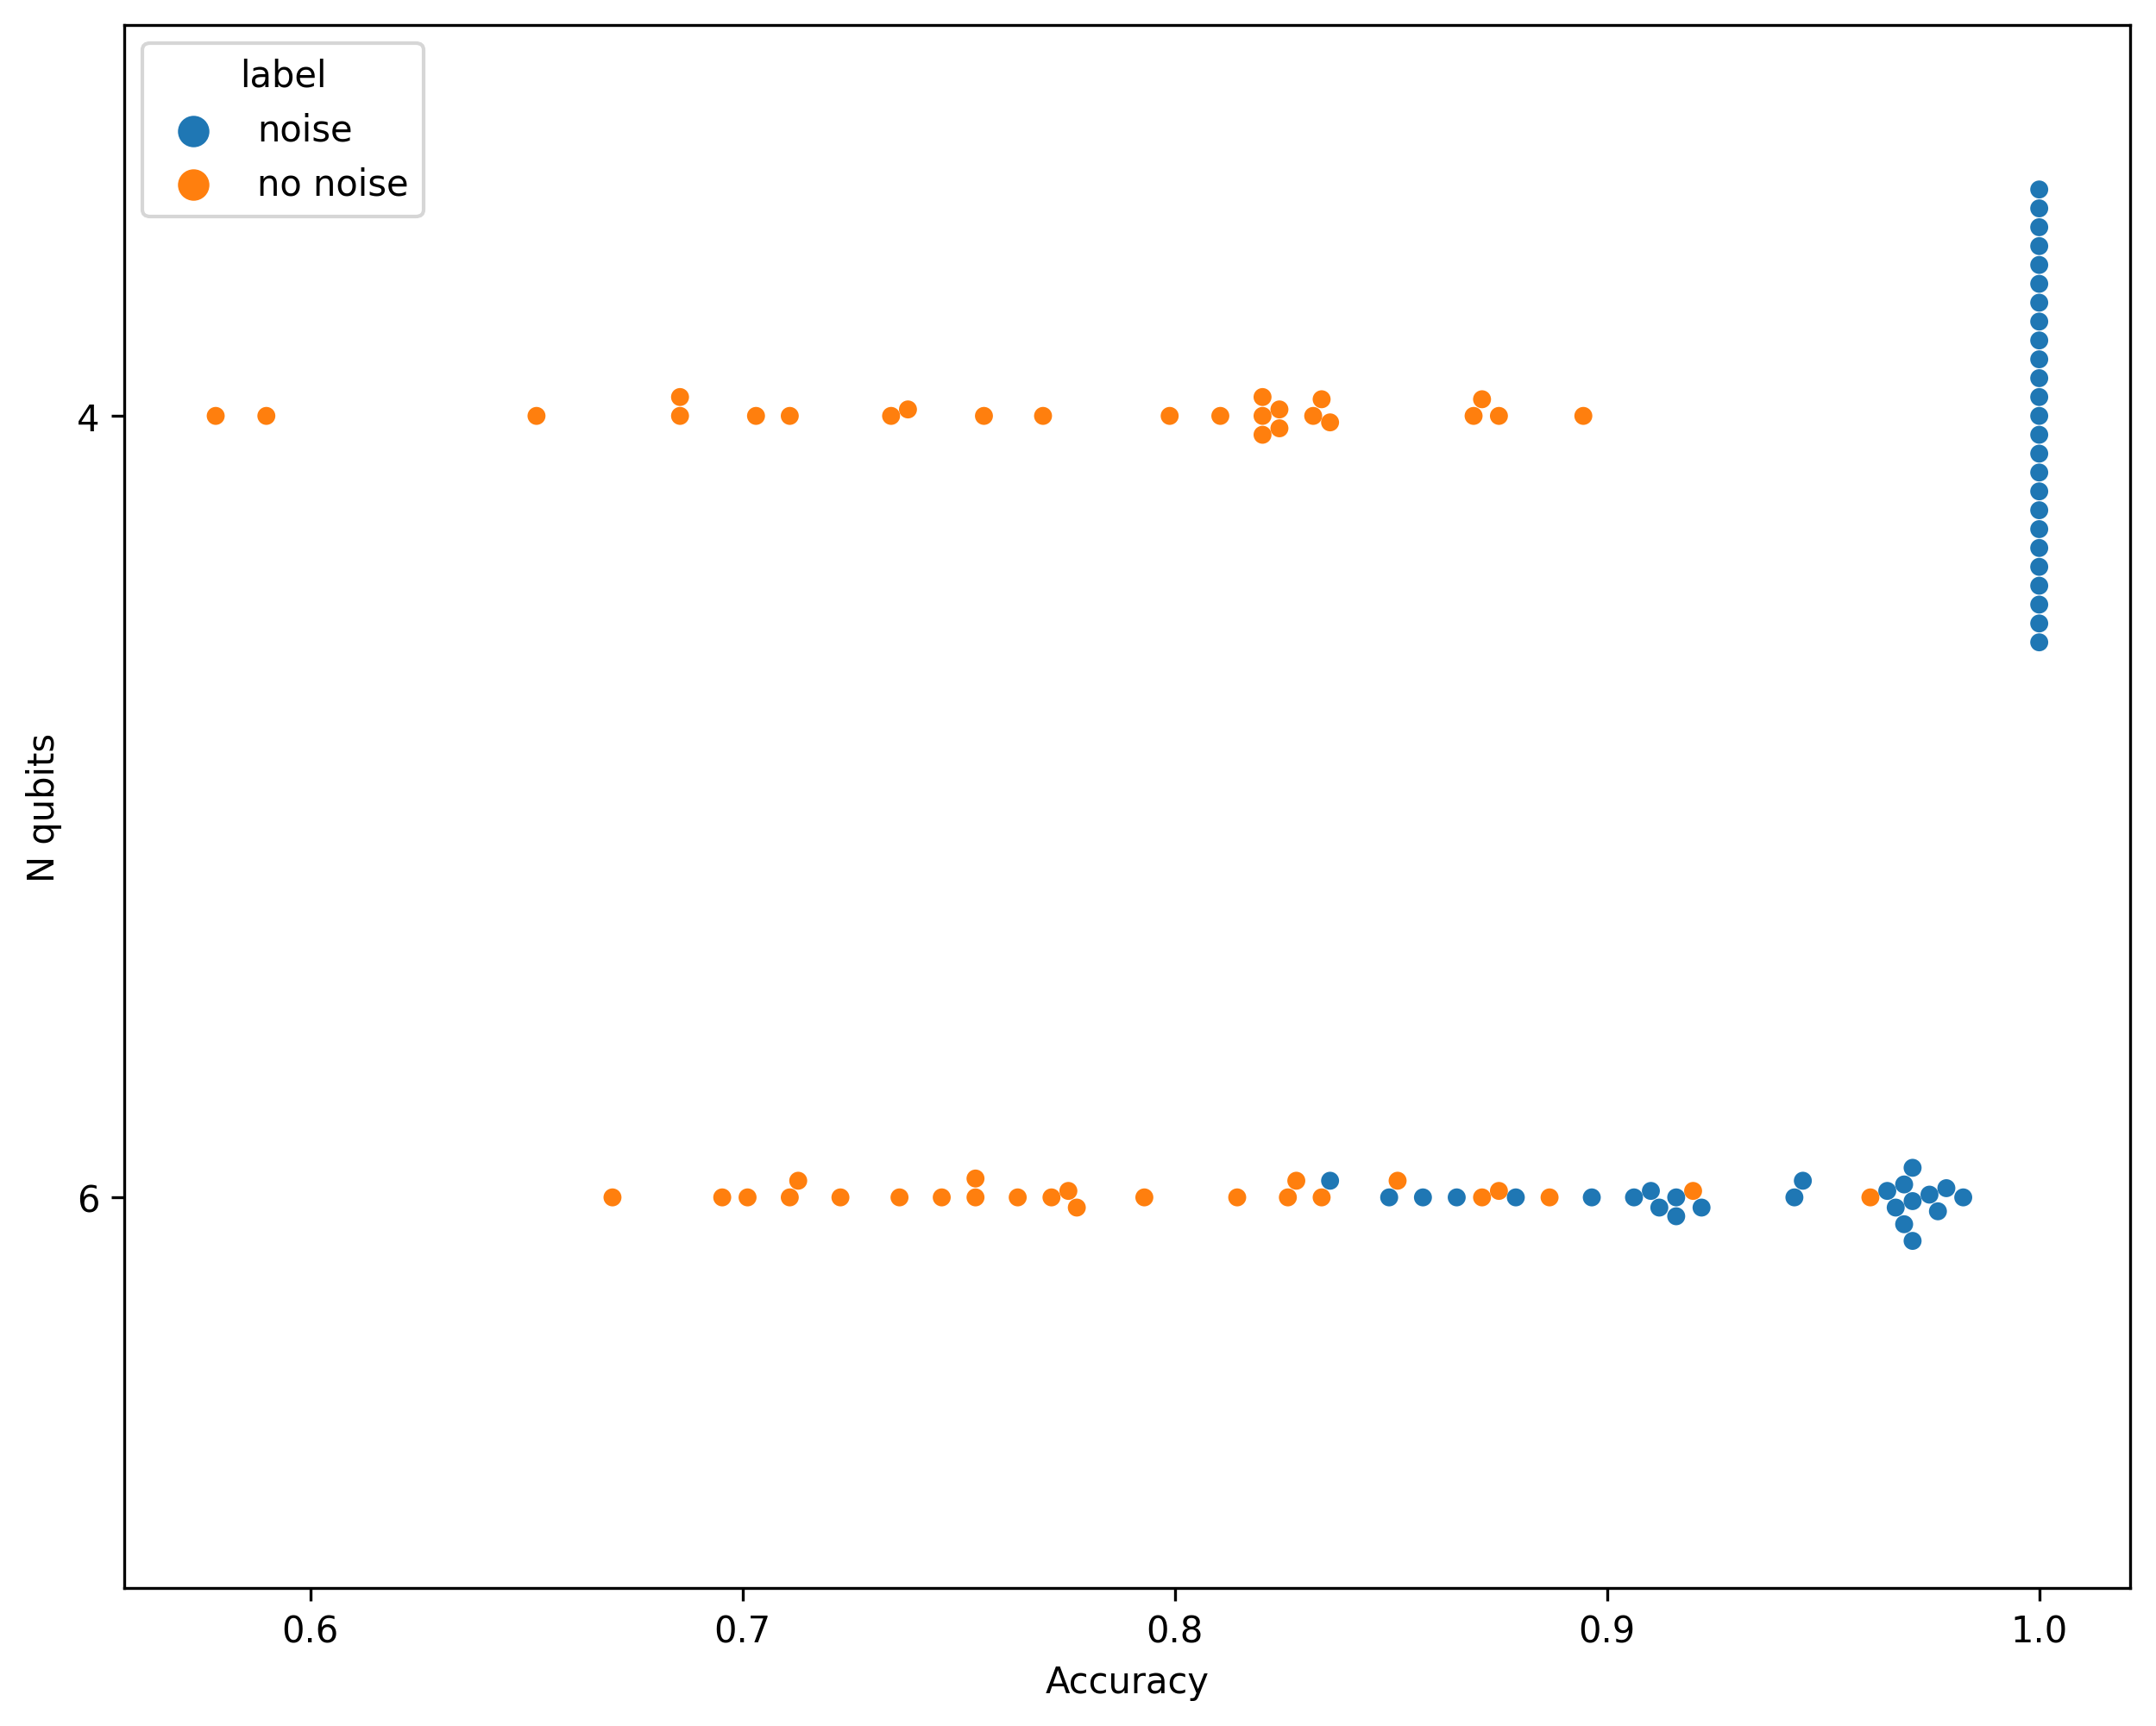

In [34]:
import seaborn as sns
plt.figure(figsize=(10,8), dpi=300)
sns.swarmplot(data=acc_df, x='Accuracy', hue='label', y='N qubits', orient='h')
plt.savefig('acc_4_6.jpeg')
plt.show()